In [34]:
# file_path =r"C:\Users\ricca\Documents\PhD\Potentials\SI_cif.txt"
file_path =r"/Users/ncanale/Documents/OREO/Channeling_Potential/AMS_DATA (1).cif"

with open(file_path, "r") as cif:
    lines = cif.readlines()
# a = lines[lines.index("_cell_length_a 5.43070"+"\n")].split()[1]
matchers = ["_cell_length_a", "_cell_length_b", "_cell_length_c", "_cell_angle_alpha", "_cell_angle_beta", "_cell_angle_gamma"]
values = [line for line in lines if any(matcher in line for matcher in matchers)]#[0].split()[1]
a, b, c, alfa, beta, gamma = [float(element.split()[1]) for element in values]
#queste variabili sono grà trasformate in numero
print (a, b, c, alfa, beta, gamma)
###################### ORA TOCCA AI VETTORI #######################################

vectors = []
for i, line in enumerate(lines):
    if line.startswith("_space_group_symop_operation_xyz"):
        for j in range(i + 1, len(lines)):
            if lines[j].startswith("loop_"):
                break
            elif lines[j].startswith(" "):
                vectors.append(lines[j].strip())
print(vectors)
vectors = [vector.strip("'").split(",") for vector in vectors] # remove '
print(vectors)

for vector in vectors:
    for i in range(len(vector)):
        vector[i]= vector[i].replace("x", str(a))
        vector[i]= vector[i].replace("y", str(b))
        vector[i]= vector[i].replace("z", str(c))
print(vectors)

5.4307 5.4307 5.4307 90.0 90.0 90.0
["'x,y,z'", "'x,1/2+y,1/2+z'", "'1/2+x,y,1/2+z'", "'1/2+x,1/2+y,z'", "'3/4+z,3/4-x,1/4+y'", "'3/4+z,1/4-x,3/4+y'", "'1/4+z,3/4-x,3/4+y'", "'1/4+z,1/4-x,1/4+y'", "'-y,1/2+z,1/2-x'", "'-y,+z,-x'", "'1/2-y,1/2+z,-x'", "'1/2-y,+z,1/2-x'", "'3/4+x,3/4-y,1/4+z'", "'3/4+x,1/4-y,3/4+z'", "'1/4+x,3/4-y,3/4+z'", "'1/4+x,1/4-y,1/4+z'", "'-z,1/2+x,1/2-y'", "'-z,+x,-y'", "'1/2-z,1/2+x,-y'", "'1/2-z,+x,1/2-y'", "'3/4+y,3/4-z,1/4+x'", "'3/4+y,1/4-z,3/4+x'", "'1/4+y,3/4-z,3/4+x'", "'1/4+y,1/4-z,1/4+x'", "'-x,1/2+y,1/2-z'", "'-x,+y,-z'", "'1/2-x,1/2+y,-z'", "'1/2-x,+y,1/2-z'", "'1/2+x,-z,1/2-y'", "'1/2+x,1/2-z,-y'", "'+x,-z,-y'", "'+x,1/2-z,1/2-y'", "'3/4-z,3/4+y,1/4+x'", "'3/4-z,1/4+y,3/4+x'", "'1/4-z,3/4+y,3/4+x'", "'1/4-z,1/4+y,1/4+x'", "'1/2+y,-x,1/2-z'", "'1/2+y,1/2-x,-z'", "'+y,-x,-z'", "'+y,1/2-x,1/2-z'", "'3/4-x,3/4+z,1/4+y'", "'3/4-x,1/4+z,3/4+y'", "'1/4-x,3/4+z,3/4+y'", "'1/4-x,1/4+z,1/4+y'", "'1/2+z,-y,1/2-x'", "'1/2+z,1/2-y,-x'", "'+z,-y,-x'", "'+z,1/2-y,

In [35]:
'''###Nicola's code
# Carica la struttura dal file CIF
structure = Structure.from_file("AMS_DATA (1).cif")
# structure = SiteCollection.from_file("AMS_DATA.cif")
print(structure)
supercell = structure.make_supercell([2,2,2])
print(structure)

# print(structure)
# Specifica il piano di interesse (ad esempio: x = 0)
plane = cgu.Plane.from_coefficients(1,0,0,0)
# print(plane)

# Trova gli atomi nella posizione del piano di interesse
tolerance = 1e-10
atoms_in_plane = []
positions =[]
for site in structure:
    # print(site)
    # if plane.is_in_plane(site,tolerance):
        # print (site)
        # atoms_in_plane.append(site)
    dist = float(plane.distance_to_point(site.coords))
    # positions.append(site.coords)
    # print(positions)
    # print(dist, " - ", tolerance)
    # print ("d-t ", dist-tolerance)
    if abs(dist) <= tolerance:
        # print(site)
        atoms_in_plane.append(site.coords)


for atoms in atoms_in_plane:
    print (atoms)
    positions.append(list(atoms))
    # print(type(atoms))
# print(atoms_in_plane)
print(positions)
# Plot delle posizioni degli atomi nello spazio 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(positions[:,0], positions[:,1], positions[:,2])
ax.scatter(positions[:,0], positions[:,1], positions[:,2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()'''

'###Nicola\'s code\n# Carica la struttura dal file CIF\nstructure = Structure.from_file("AMS_DATA (1).cif")\n# structure = SiteCollection.from_file("AMS_DATA.cif")\nprint(structure)\nsupercell = structure.make_supercell([2,2,2])\nprint(structure)\n\n# print(structure)\n# Specifica il piano di interesse (ad esempio: x = 0)\nplane = cgu.Plane.from_coefficients(1,0,0,0)\n# print(plane)\n\n# Trova gli atomi nella posizione del piano di interesse\ntolerance = 1e-10\natoms_in_plane = []\npositions =[]\nfor site in structure:\n    # print(site)\n    # if plane.is_in_plane(site,tolerance):\n        # print (site)\n        # atoms_in_plane.append(site)\n    dist = float(plane.distance_to_point(site.coords))\n    # positions.append(site.coords)\n    # print(positions)\n    # print(dist, " - ", tolerance)\n    # print ("d-t ", dist-tolerance)\n    if abs(dist) <= tolerance:\n        # print(site)\n        atoms_in_plane.append(site.coords)\n\n\nfor atoms in atoms_in_plane:\n    print (atoms)\n   

# CODICE STRUTTURA

## Parte 1

Elementi da cambiare al variare delle analisi: 
path_cif
asse

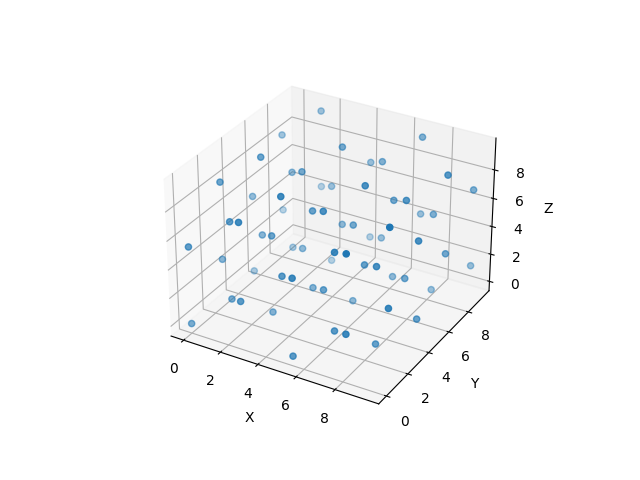

In [36]:
%matplotlib widget
import numpy as np 
from pymatgen.core import Structure
from pymatgen.analysis.chemenv.utils import coordination_geometry_utils as cgu
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Caricamento della struttura cristallina dal cif file ##
## Upload of the crystal structure from cif file ##
path_cif=r"AMS_DATA (1).cif"

# path_cif = r"C:\Users\ricca\Downloads\AMS_DATA (1).cif"
# path_cif =r"/Users/ncanale/Documents/OREO/Channeling_Potential/AMS_DATA (1).cif"

structure = Structure.from_file(path_cif)

## Replicazione della cella unitaria per ottenere più atomi ##
## It repeats the unitary cell to have more atoms ##
supercell = structure.make_supercell([2, 2, 2])

## Estrazione delle posizioni degli atomi ##
## Extract atoms' positions ##
positions = structure.cart_coords

## Plot delle posizioni degli atomi nello spazio 3D ##
## Plot of positions in 3D space ##
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(positions[:,0], positions[:,1], positions[:,2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()



In [37]:
## Small script to evaluate the distances between two points. ##
## one can check with the widget on the graph and modify here ##
def distance_point(x1,y1,z1,x2,y2,z2):
    d = np.sqrt((x1-x2)**2+(y1-y2)**2+(z1-z2)**2)
    return abs(d)


xa,ya =2.73, 2.76
xb,yb = 4.05, 1.37
za,zb =0. , 0.

print(distance_point(xa,ya,za,xb,yb,zb))

1.916898536699321


In [38]:
'''path_cif = r"C:\Users\ricca\Downloads\AMS_DATA (1).cif"

# Carica la struttura dal file CIF
structure = Structure.from_file(path_cif)
# print(structure)
# Specifica il piano di interesse (ad esempio: x = 0)
plane = cgu.Plane.from_coefficients(1,0,0,0)
# print(plane)

# Trova gli atomi nella posizione del piano di interesse
tolerance = 1.0
atoms_in_plane = []
for site in structure:
    # print(site)
    # if plane.is_in_plane(site,tolerance):
        # print (site)
        # atoms_in_plane.append(site)
    dist = float(plane.distance_to_point(site.coords))
    print(site.coords)
    # print(dist, " - ", tolerance)
    # print ("d-t ", dist-tolerance)
    if abs(dist) < tolerance:
        # print(site)
        atoms_in_plane.append(site)



print(atoms_in_plane)'''

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 15-16: truncated \UXXXXXXXX escape (2784526256.py, line 1)

In [39]:
'''#chatgpt code for plane intersection
# Estrazione delle posizioni degli atomi sul piano (1 0 0)
positions = []
for site in structure:
    if site.frac_coords[0] == 0.5:  # controlla se il primo coordinata del sito è 0.5
        positions.append(site.coords)

# Plot delle posizioni degli atomi nello spazio 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter([p[0] for p in positions], [p[1] for p in positions], [p[2] for p in positions])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()'''

"#chatgpt code for plane intersection\n# Estrazione delle posizioni degli atomi sul piano (1 0 0)\npositions = []\nfor site in structure:\n    if site.frac_coords[0] == 0.5:  # controlla se il primo coordinata del sito è 0.5\n        positions.append(site.coords)\n\n# Plot delle posizioni degli atomi nello spazio 3D\nfig = plt.figure()\nax = fig.add_subplot(111, projection='3d')\nax.scatter([p[0] for p in positions], [p[1] for p in positions], [p[2] for p in positions])\nax.set_xlabel('X')\nax.set_ylabel('Y')\nax.set_zlabel('Z')\nplt.show()"

In [40]:
'''%matplotlib widget
from pymatgen.core import Structure
from pymatgen.analysis.chemenv.utils import coordination_geometry_utils as cgu
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Caricamento della struttura cristallina del silicio
# path_cif = r"C:\Users\ricca\Downloads\AMS_DATA (1).cif"
path_cif =r"/Users/ncanale/Documents/OREO/Channeling_Potential/AMS_DATA (1).cif"
structure = Structure.from_file(path_cif)

# Replicazione della cella unitaria per ottenere una cella superiore
supercell = structure.make_supercell([2, 2, 2])

# Estrazione delle posizioni degli atomi
positions = structure.cart_coords

### piano
x = positions[:,0].max()
#x = positions[:,0].min()
# Definiamo il vettore perpendicolare al piano e un punto del piano
normal_vector = np.array([1, 1, 0])
point_on_plane = np.array([x/2, x/2, x/2])

# Calcoliamo il valore di D utilizzando la formula del piano
D = -np.dot(normal_vector, point_on_plane)
y = np.linspace(-5, 5, 100)
z = np.linspace(-5, 5, 100)
X = (-normal_vector[1]*Y - normal_vector[2]*Z - D)/(normal_vector[0])

# Plot delle posizioni degli atomi nello spazio 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(positions[:,0], positions[:,1], positions[:,2])
ax.plot_surface(X, Y, Z)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()'''

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 278-279: truncated \UXXXXXXXX escape (4067138911.py, line 1)

In [41]:
'''posizioni_proiezioni = []
for vettore_posizione in vettori_posizione:
    prodotto_scalare = np.dot(vettore_posizione, vettore_normale)
    posizione_proiezione = prodotto_scalare / lunghezza_normale
    posizione_proiezione_vettoriale = np.array(vettore_posizione) - (posizione_proiezione * np.array(vettore_normale))
    posizioni_proiezioni.append(posizione_proiezione_vettoriale)'''

## Select the axis of analysis in the string ##
asse = "1 0 0"
print ("asse ", np.fromstring(asse, dtype=int, sep=" "))

## Creates the axis vector to project all the points on the plane (normalizing it)##
norm_vector = np.fromstring(asse, dtype=int, sep=" ")
norma = np.linalg.norm(norm_vector)
norm_vector = norm_vector/norma
#print(norma)

##Project the atom position on the plane##
vector_projections = []
for position in positions:
    pr_scalar = np.dot(position, norm_vector) * norm_vector
    # print(" position", position)
    # print(" pr_scalar", pr_scalar)
    #projection = pr_scalar/norma
    vector_projection = np.array(position) - (pr_scalar) # projection *
    vector_projections.append(vector_projection)

# print(vector_projections)


asse  [1 0 0]


[0. 0. 0.]
[0.     0.     5.4307]
[0.     5.4307 0.    ]
[0.     5.4307 5.4307]
[0. 0. 0.]
[0.     0.     5.4307]
[0.     5.4307 0.    ]
[0.     5.4307 5.4307]
[0.      2.71535 2.71535]
[0.      2.71535 8.14605]


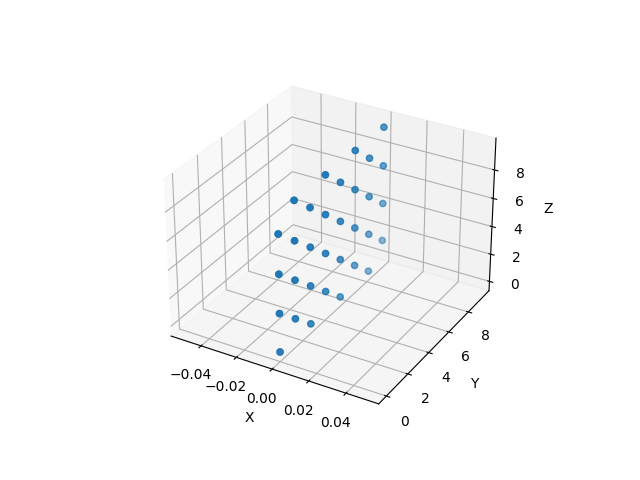

In [42]:
## Since the cif projection gives slightly different results around 0 for same atoms it has to be thresholded##
soglia = 1e-10
for prj in vector_projections: #to make all np.arrays
    # print (atoms)
    prj[np.abs(prj)< soglia] = 0.0
    #print(prj)
#print(vector_projections)
ndarray_projs = np.array(vector_projections)
for i in range(0,10):
    print(ndarray_projs[i])

## Plot the projected points ##
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ndarray_projs[:,0], ndarray_projs[:,1], ndarray_projs[:,2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

rotation axis [ 0. -1.  0.]
deg of rotation 90.0


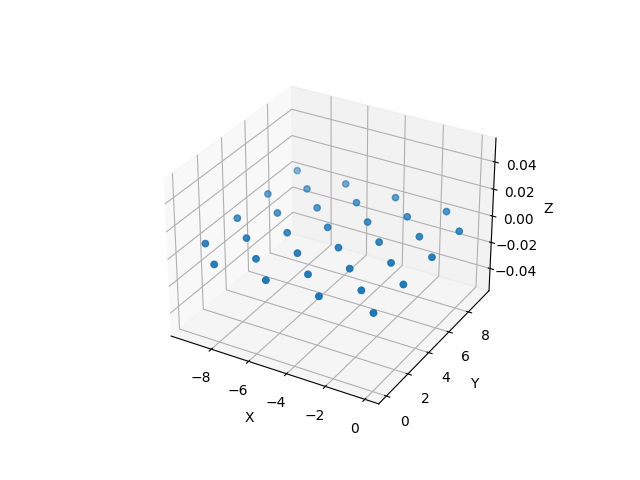

In [43]:
## Vettori di base del piano ##
## Base vector of the xy,yz,zx planes ##
x_base = np.array([1, 0, 0])
y_base = np.array([0, 1, 0])
z_base = np.array([0, 0, 1])

## Creates a Rotation matrix to place all the projected points onto the xy plane ##
rotation_axis = np.cross(norm_vector, z_base)
print("rotation axis",rotation_axis)
angle = np.arccos(np.dot(norm_vector,z_base)/(np.sqrt(norm_vector[0]**2 + norm_vector[1]**2 + norm_vector[2]**2)*np.sqrt(z_base[0]**2 + z_base[1]**2 + z_base[2]**2)))
print("deg of rotation",np.degrees(angle))
c=np.cos(angle)
def rotation_matrix(axis, theta):
    """
    Restituisce la matrice di rotazione per una rotazione attorno all'asse specificato
    di un angolo specificato in radianti utilizzando la formula di Rodrigues.
    """
    axis = axis / np.sqrt(np.dot(axis, axis))
    a = np.cos(theta/2.)
    b, c, d = -axis * np.sin(theta/2)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

R = rotation_matrix(rotation_axis, angle)

'''# Calcola l'angolo tra il vettore asse e i vettori di base
angolo_x = np.arccos(abs(norm_vector[0])/np.sqrt(norm_vector[0]**2 + norm_vector[1]**2 + norm_vector[2]**2))
angolo_y = np.arccos(abs(norm_vector[1])/np.sqrt(norm_vector[0]**2 + norm_vector[1]**2 + norm_vector[2]**2))
angolo_z = np.arccos(abs(norm_vector[2])/np.sqrt(norm_vector[0]**2 + norm_vector[1]**2 + norm_vector[2]**2))

print(np.degrees(angolo_x), np.degrees(angolo_y), np.degrees(angolo_z))
c1, s1 = np.cos(angolo_x), np.sin(angolo_x)
R1 = np.array(((1, 0, 0), (0, c1, -s1), (0, s1, c1)))
    
c2, s2 = np.cos(angolo_y), np.sin(angolo_y)
R2 = np.array(((c2, 0, s2), (0, 1, 0), (-s2, 0, c2))) 

c3, s3 = np.cos(angolo_z), np.sin(angolo_z)
R3 = np.array(((c3, -s3, 0), (s3, c3, 0), (0, 0, 1))) 
    
R = np.dot(R1, R2, R3)'''

'''if (norm_vector == np.array([1, 0, 0])).all():
    asse = "1, 0, 0"
    theta = np.radians(0)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s, 0), (s, c, 0), (0, 0, 1)))
elif (norm_vector == np.array([1, 1, 0])).all():
    asse = "1, 1, 0"
    theta = np.radians(45)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s, 0), (s, c, 0), (0, 0, 1)))
elif (norm_vector == np.array([1, 1, 1])).all():
    asse = "1, 1, 1"
    theta1 = np.radians(45)
    c1, s1 = np.cos(theta1), np.sin(theta1)
    R1 = np.array(((c, -s, 0), (s, c, 0), (0, 0, 1)))
    
    theta2 = np.radians(0)
    c2, s2 = np.cos(theta2), np.sin(theta2)
    R2 = np.array(((1, 0, 0), (0, c, -s), (0, s, c))) 
    
    R = np.dot(R1, R2)'''

r_ndarray_projs = []
for p in ndarray_projs:
    r_ndarray_proj = np.dot(R, p)
    #print("rotated",r_ndarray_proj)
    r_ndarray_projs.append(r_ndarray_proj)
    
for prj in r_ndarray_projs: #to make all np.arrays
    # print (atoms)
    prj[np.abs(prj)< soglia] = 0.0
    
## Plots the rotated projected points in xy plane ##
r_ndarray_projs = np.array(r_ndarray_projs)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(r_ndarray_projs[:,0], r_ndarray_projs[:,1], r_ndarray_projs[:,2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

In [44]:
## Extracts the x,y position of the projected atoms to create the Potential maps ##

x_positions = []
y_positions = []
atom_positions = []

for a in range(0,len(r_ndarray_projs)):
    atom_positions.append((round(r_ndarray_projs[a][0],3),round(r_ndarray_projs[a][1],3)))
    x_positions.append(round(r_ndarray_projs[a][0],3))
    y_positions.append(round(r_ndarray_projs[a][1],3))
    if r_ndarray_projs[a][2] != 0: ## Check if everitying is really on plane
        print ("watch this z : ", round(r_ndarray_projs[a][2],2))
# print(atom_positions)

## Takes only the unique values of positions, to remove multiplicity ##
atom_positions = list(set(atom_positions))
# print("at_pos", atom_positions)
print("unique atom positions ", len(atom_positions))
# print(type(atom_positions))

for j in range(0,len(atom_positions)-1):
    print(atom_positions[j],atom_positions[j+1])
    print (distance_point(atom_positions[j][0],atom_positions[j][1],0,atom_positions[j+1][0],atom_positions[j+1][1],0))
    # if atom[0]==0.0:
        # print(atom)

unique atom positions  32
(-6.788, 4.073) (-6.788, 6.788)
2.715
(-6.788, 6.788) (-1.358, 9.504)
6.071371838390397
(-1.358, 9.504) (-8.146, 8.146)
6.922507349219646
(-8.146, 8.146) (-5.431, 8.146)
2.7150000000000007
(-5.431, 8.146) (-9.504, 9.504)
4.293424390856323
(-9.504, 9.504) (-2.715, 0.0)
11.679749012714272
(-2.715, 0.0) (-4.073, 1.358)
1.9205020177026637
(-4.073, 1.358) (-2.715, 2.715)
1.9197950411437157
(-2.715, 2.715) (-2.715, 5.431)
2.716
(-2.715, 5.431) (0.0, 8.146)
3.8395898218429534
(0.0, 8.146) (-9.504, 6.788)
9.60053019369243
(-9.504, 6.788) (-6.788, 9.504)
3.841004035405325
(-6.788, 9.504) (-8.146, 0.0)
9.60053019369243
(-8.146, 0.0) (-4.073, 4.073)
5.760091839545616
(-4.073, 4.073) (-5.431, 0.0)
4.293424390856325
(-5.431, 0.0) (-1.358, 1.358)
4.293424390856325
(-1.358, 1.358) (-9.504, 1.358)
8.145999999999999
(-9.504, 1.358) (-8.146, 5.431)
4.293424390856324
(-8.146, 5.431) (-8.146, 2.715)
2.716
(-8.146, 2.715) (-4.073, 6.788)
5.760091839545616
(-4.073, 6.788) (-5.431, 

In [56]:
a_Si = [1.876, 2.617, 0.8604, 0.3903, 0.07769 ]
b_Si = [62.11, 18.68, 3.935, 0.7690, 0.0823]
a_err_Si = 0.5067 * 10**(-3)
B_Si = [b/(4*(np.pi)**(2)) for b in b_Si]

alfa = [0.1, 0.55, 0.35]
beta = [6.0, 1.2, 0.3]

u_1 = 0.075 #preso da sytov thesis
z = 1
a_0 = 0.53 #Angstrom
e = 1.6E-19
N = 4.995E-2 #atomic concentration
Z = 14
d_pl = 1.36 #(100)
d_at = 5.43 #<100>

# d_at_111 = [2.35,7.05]
d_at=sum(d_at_111)/len(d_at_111)
# print("d_at",d_at)
a_TF = (9*np.pi**2/(128*Z))**(1/3)*a_0

## DT approximation in a 2D space
def U_DT_2D(x, y, x_0, y_0): ##AXIAL DT
    U1 = 2/d_at*Z*z*e*a_0
    k1 = [(a_Si[i]/(B_Si[i]+2*u_1**2))*np.exp(-((x-x_0)**2+(y-y_0)**2)/(B_Si[i]+2*u_1**2)) for i in range(0,len(a_Si))]
    k = sum(k1)
    return U1*k


nat = 2 ##number of neighbor atoms
d = d_at/(2*np.sqrt(2))

## Definisci il range di x e y ##
## Define x,y range from positions ##
x = np.linspace(min(x_positions), max(x_positions), 1000)
y = np.linspace(min(y_positions), max(y_positions), 1000)
xx, yy = np.meshgrid(x, y)

# x_0 = [0] * 100
# y_0 = [0] * 100
# xx_0, yy_0 = np.meshgrid(x_0,y_0)

## Caluclates the potential in position (atom) ##
U_2D= np.zeros_like(xx)
for atom in atom_positions:
    U_2D += U_DT_2D(xx,yy,atom[0],atom[1])/e
    #print(x_positions[i],y_positions[i])
    #print(U_2D)
#print(len(U_2D))
gradient_2d  = np.gradient(U_2D)

E_tot= np.zeros_like(xx)
# print (xx[10,10])
# print(gradient_2d[1][10][10])
for  i in range(0, len(gradient_2d[0])):
    for  j in range(0, len(gradient_2d[1])):
        E_tot[i,j] = np.sqrt(gradient_2d[0][i][j]**2 + gradient_2d[1][i][j]**2)

    # print (np.shape(maps))
    # for elements in maps:
        # print (elements)
    #    g_plot.append(np.sqrt(elements[0]**2+elements[1]**2))
# print(g_plot)

#U_2D_s = np.sum(U_2D, axis=0)

U_max, U_min = [],[]
for U in U_2D:
    U_max.append(max(U))
    U_min.append(min(U))
U_top, U_bottom = max(U_max), min(U_min)


E_tot_max, E_tot_min = [],[]
for E in E_tot:
    E_tot_max.append(max(E))
    E_tot_min.append(min(E))
E_tot_top, E_tot_bottom = max(E_tot_max), min(E_tot_min)

# print(U_top, U_bottom) ## TO have a range for the graph color levels
print(E_tot_top, E_tot_bottom) ## TO have a range for the graph color levels


#U_2D = np.array([U_DT_2D(xx+j*d, yy+j*d) for j in range(-nat, nat)])
#print(U_2D_sum.shape)
#print(U_2D)
#U_2D_sum = sum(U_2D)/e
#U_2D_s = U_2D_s - min(U_2D_s)

#n = 20
#levels = [i*(U_2D_s.max()-U_2D_s.min())/n for i in range (0, n)]
#levels = np.linspace(4, 32, 100)


3.4932071524969546 0.00038462634795558524


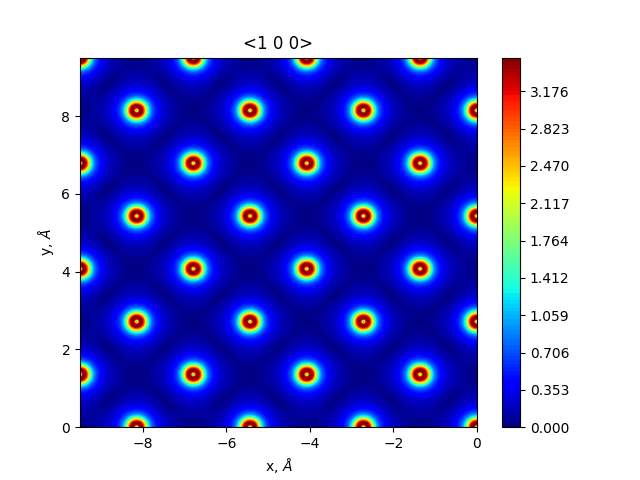

In [55]:
## Crea il grafico
## Plots the potential

# levels_log = np.logspace(0,np.log10(U_top),base = 10.0,endpoint = True, num = 10)
# print (np.log10(U_bottom),np.log10(U_top))
# print(levels_log)

levels = np.linspace(U_bottom, U_top, 50)
level_e =np.linspace(E_tot_bottom, E_tot_top, 100)

fig, ax=plt.subplots()
# plt.contourf(xx, yy, U_2D,levels,  cmap='jet') #levels,
# plt.contourf(xx, yy, gradient_2d[0], levels_0, cmap='jet') #levels,
plt.contourf(xx, yy, E_tot, level_e, cmap='jet') #levels,
# plt.contourf(xx, yy, gradient_2d[1], levels_1, cmap='jet') #levels,
# plt.contourf(xx, yy, U_2D,levels_log,  cmap='jet') #levels,
plt.colorbar()
plt.title("<"+ asse +">") 
plt.xlabel('x, $\AA$')
plt.ylabel('y, $\AA$')
plt.show()

For 1D graph

Selected axis:  [1. 1. 1.]
[[0.       0.       0.      ]
 [1.357675 1.357675 1.357675]
 [5.4307   5.4307   5.4307  ]
 [6.788375 6.788375 6.788375]]


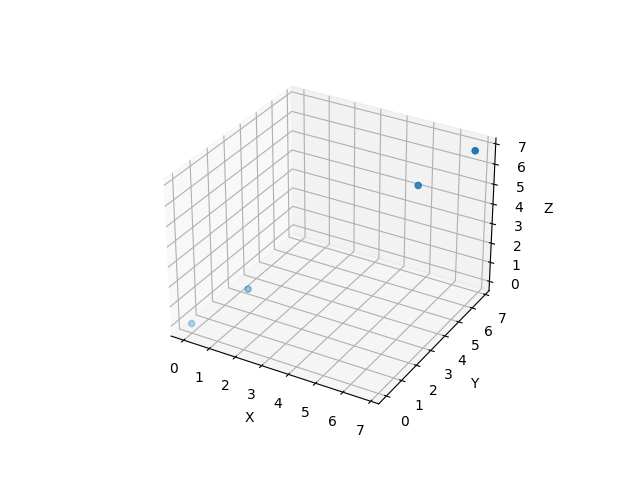

In [ ]:
## chech if points are on the selected axis
# def punto_su_retta(x, y, z, l, m, n):
#     # Calcola il parametro t della retta per il punto dato
#     t = None
#     if l != 0:
#         t = x / l
#     elif m != 0:
#         t = y / m
#     elif n != 0:
#         t = z / n
    
#     # Controlla se il punto giace sulla retta
#     if t is not None and x == t * l and y == t * m and z == t * n:
#         return True
#     else:
#         return False
    
print("Selected axis: ", norm_vector*norma)

# line equation from (l,m,n) : x-x0/l - y-y0/m - z-z0/n = 0
l = norm_vector[0]
m = norm_vector[1]
n = norm_vector[2]
# l = norm_vector[0]*norma
# m = norm_vector[1]*norma
# n = norm_vector[2]*norma

# for position in positions:
#     test = punto_su_retta(position[0],position[1],position[2],l,m,n)
#     if test == True:
#         print (position)

## It checks if the scalar product between the axis vector and the position vector is near to 0,##
## if it is it means that the two vectors are parallel and so we can look at that atoms ##
def punto_retta_scalare(v1,r):
    r_norm = np.linalg.norm(r)
    v1_norm = np.linalg.norm(v1)
    # print (round(v1_norm,2))
    # print (round(r_norm,2))
    pr_scalar=np.dot(v1, r)
    # print (pr_scalar, " -- ", v1_norm*r_norm)
    if abs(pr_scalar - v1_norm*r_norm)<0.2:
        return True
    else:
        return False
pos_ax =[]
for position in positions:
    test2 = punto_retta_scalare(position,norm_vector*norma)
    if test2 == True:
        # print (position)
        pos_ax.append(position)
        # pass
pos_ax=np.sort(np.array(pos_ax),0)
print (pos_ax)
    

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pos_ax[:,0], pos_ax[:,1], pos_ax[:,2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()
